In [1]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('0hp_all_faults.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=784
stride=300

X=[]
Y=[]


for k in df['fault'].unique():
    
    df_temp_2 = df[df['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],28,28,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [4]:
X.shape

(9246, 28, 28, 1)

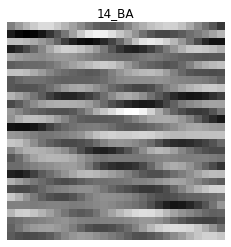

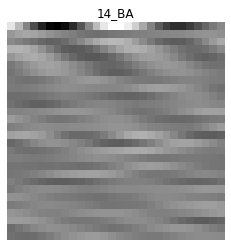

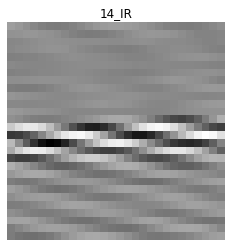

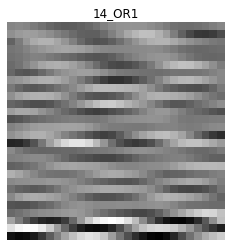

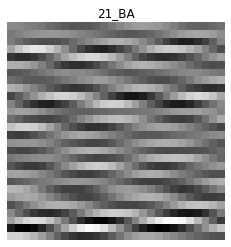

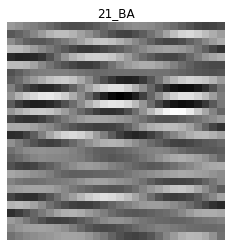

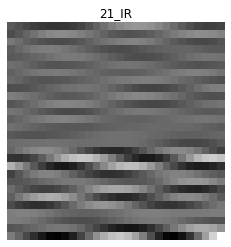

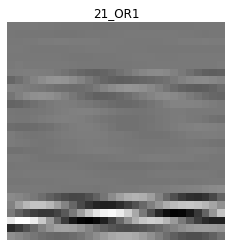

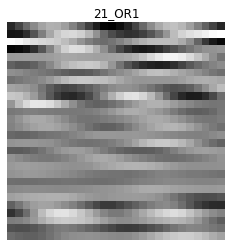

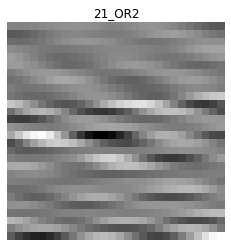

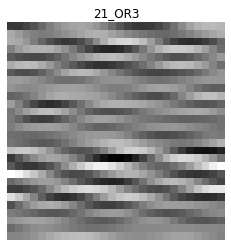

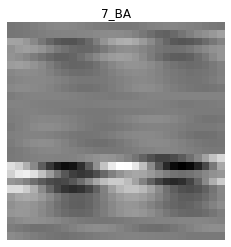

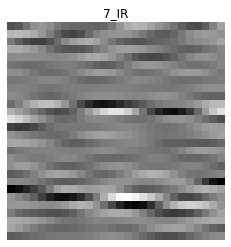

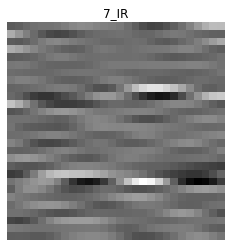

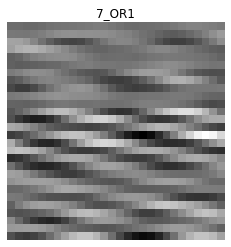

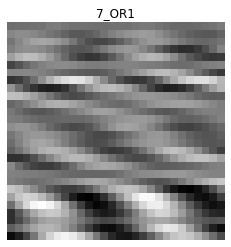

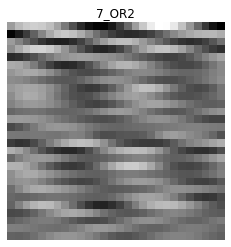

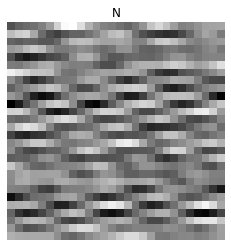

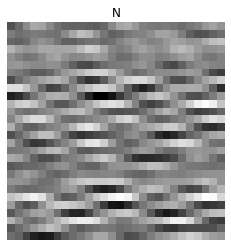

In [5]:
from matplotlib.pyplot import imread


for idx in range(0,9244,500):
    img=X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [6]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)


In [7]:
# X_pre_cnn = X.reshape(X.shape[0],X.shape[1]*X.shape[2])

# from sklearn.manifold import TSNE

# X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X_pre_cnn)

# tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

# tSNEdf['Fault']=Y


# # Plot the PC-1 and PC-2
# fig, ax = plt.subplots(figsize=(7,7))
# sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
#     data=tSNEdf,
#     legend="full",
#     alpha=0.3)
# plt.show()

In [8]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D



# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')



no_classes = len(df['fault'].unique())

cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(X.shape[1],X.shape[2],1),padding='same'))

cnn_model.add(MaxPooling2D((2, 2),strides=(2, 2),padding='same'))

cnn_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))

cnn_model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='same'))

# cnn_model.add(Conv2D(128, (5, 3), activation='relu',padding='same'))
                 
# cnn_model.add(MaxPooling2D(pool_size=(5, 2),strides=(3, 3),padding='same'))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
            
cnn_model.add(Dense(no_classes, activation='softmax'))

cnn_model.summary()

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

In [9]:
batch_size =200
epochs = 20
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/20
33/33 [==============================] - 3s 77ms/step - loss: 1.8209 - accuracy: 0.3951 - val_loss: 1.0512 - val_accuracy: 0.7203
Epoch 2/20
33/33 [==============================] - 2s 65ms/step - loss: 0.6669 - accuracy: 0.8008 - val_loss: 0.5066 - val_accuracy: 0.8345
Epoch 3/20
33/33 [==============================] - 2s 64ms/step - loss: 0.3118 - accuracy: 0.9056 - val_loss: 0.2511 - val_accuracy: 0.9243
Epoch 4/20
33/33 [==============================] - 2s 64ms/step - loss: 0.2064 - accuracy: 0.9354 - val_loss: 0.1825 - val_accuracy: 0.9405
Epoch 5/20
33/33 [==============================] - 2s 63ms/step - loss: 0.1427 - accuracy: 0.9580 - val_loss: 0.1428 - val_accuracy: 0.9546
Epoch 6/20
33/33 [==============================] - 2s 66ms/step - loss: 0.1157 - accuracy: 0.9665 - val_loss: 0.1150 - val_accuracy: 0.9621
Epoch 7/20
33/33 [==============================] - 2s 66ms/step - loss: 0.1017 - accuracy: 0.9699 - val_loss: 0.0972 - val_accuracy: 0.9730
Epoch 8/20
33

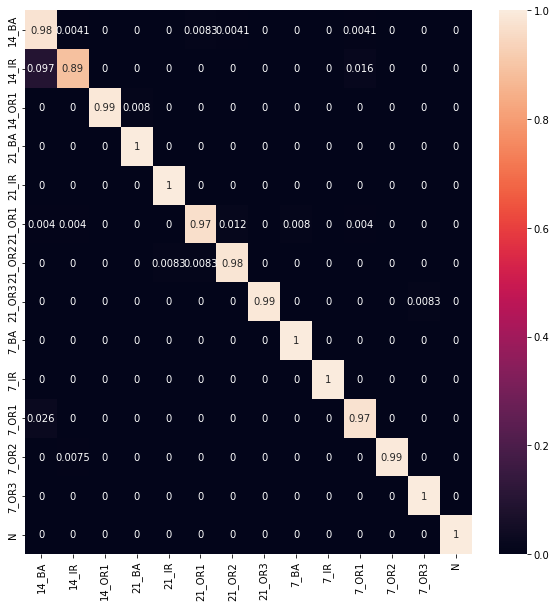

In [10]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [11]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)

C:\Users\prajj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6472 samples in 0.000s...
[t-SNE] Computed neighbors for 6472 samples in 0.848s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6472
[t-SNE] Computed conditional probabilities for sample 2000 / 6472
[t-SNE] Computed conditional probabilities for sample 3000 / 6472
[t-SNE] Computed conditional probabilities for sample 4000 / 6472
[t-SNE] Computed conditional probabilities for sample 5000 / 6472
[t-SNE] Computed conditional probabilities for sample 6000 / 6472
[t-SNE] Computed conditional probabilities for sample 6472 / 6472
[t-SNE] Mean sigma: 1.696695
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.086838
[t-SNE] KL divergence after 300 iterations: 1.870781


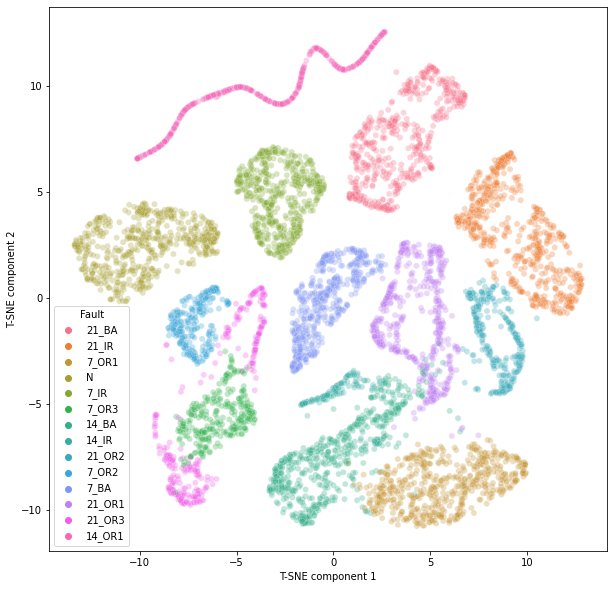

In [12]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [17]:
def T_SNE_plot(X_train,y_train,model):
    
    dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output)
    y_viz = dummy_ann.predict(X_train)
    
    from sklearn.manifold import TSNE

    X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

    tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

    tSNEdf['Fault']=inv_Transform_result(y_train)


    # Plot the PC-1 and PC-2
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
        data=tSNEdf,
        legend="full",
        alpha=0.3)
    plt.show()






def Test_model_diff_loading(load,win_len,stride,model):
    
    df = pd.read_csv('{}hp_all_faults.csv'.format(load))

#     win_len=1000
#     stride=200

    X=[]
    Y=[]


    for k in df['fault'].unique():

        df_temp_2 = df[df['fault']==k]

        for i in np.arange(0,len(df_temp_2)-(win_len),stride):
            temp = df_temp_2.iloc[i:i+win_len,:-1].values
            temp = temp.reshape((1,-1))
            X.append(temp)
            Y.append(df_temp_2.iloc[i+win_len,-1])

    X=np.array(X)
    X=X.reshape((X.shape[0],28,28,1))


    Y=np.array(Y)
    encoder2= LabelEncoder()
    encoder2.fit(Y)
    encoded_Y = encoder2.transform(Y)
    OHE_Y = to_categorical(encoded_Y)


    def inv_Transform_result(y_pred,encoder):    
        y_pred = y_pred.argmax(axis=1)
        y_pred = encoder.inverse_transform(y_pred)
        return y_pred



    y_pred=model.predict(X)
    
    print('Accuracy on Load-{}hp data is---{}%'.format(load,(model.evaluate(X,OHE_Y)[1])*100))


    Y_pred=inv_Transform_result(y_pred,encoder2)
    Y_test = Y

    from sklearn.metrics import confusion_matrix


    plt.figure(figsize=(10,10))
    cm = confusion_matrix(Y_test, Y_pred,normalize='true')
    f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
    plt.show()
    print()
    
    T_SNE_plot(X[::2,:],OHE_Y[::2,:],model)

In [25]:
# Test_model_diff_loading(load=1,win_len=784,stride=300,model=cnn_model)

In [26]:
# Test_model_diff_loading(load=2,win_len=784,stride=300,model=cnn_model)

709/709 [==============================] - 3s 4ms/step - loss: 16.9414 - accuracy: 0.2881
Accuracy on Load-3hp data is---28.813856840133667%


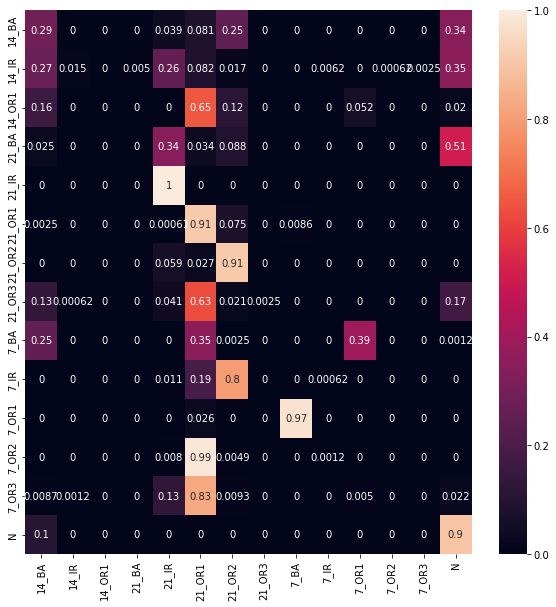

C:\Users\prajj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11344 samples in 0.001s...
[t-SNE] Computed neighbors for 11344 samples in 2.113s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11344
[t-SNE] Computed conditional probabilities for sample 2000 / 11344
[t-SNE] Computed conditional probabilities for sample 3000 / 11344
[t-SNE] Computed conditional probabilities for sample 4000 / 11344
[t-SNE] Computed conditional probabilities for sample 5000 / 11344
[t-SNE] Computed conditional probabilities for sample 6000 / 11344
[t-SNE] Computed conditional probabilities for sample 7000 / 11344
[t-SNE] Computed conditional probabilities for sample 8000 / 11344
[t-SNE] Computed conditional probabilities for sample 9000 / 11344
[t-SNE] Computed conditional probabilities for sample 10000 / 11344
[t-SNE] Computed conditional probabilities for sample 11000 / 11344
[t-SNE] Computed conditional probabilities for sample 11344 / 11344
[t-SNE] Mean sigma: 1.674033
[t-SNE] KL divergenc

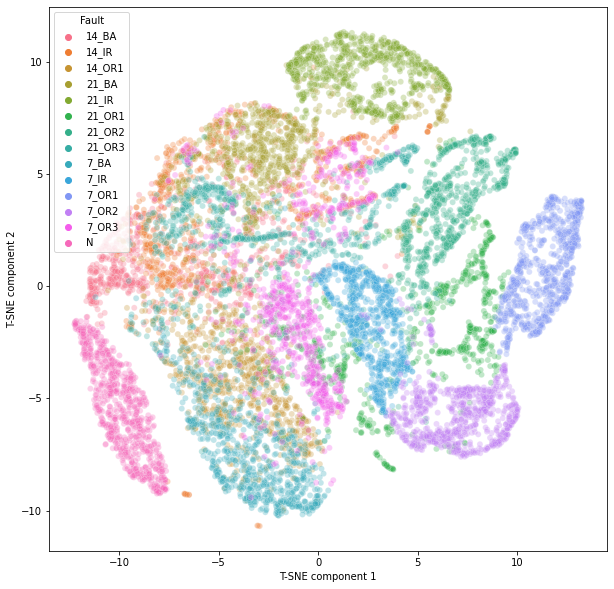

In [27]:
Test_model_diff_loading(load=3,win_len=784,stride=300,model=cnn_model)